In [1]:
import requests
import json
import os
import time

# API Endpoints
GDC_FILES_ENDPOINT = "https://api.gdc.cancer.gov/files"
GDC_DATA_ENDPOINT = "https://api.gdc.cancer.gov/data"

# Query Parameters for Fetching File IDs
query_params = {
    "filters": json.dumps({
        "op": "and",
        "content": [
            {"op": "=", "content": {"field": "cases.project.project_id", "value": "TCGA-BRCA"}},
            {"op": "=", "content": {"field": "data_type", "value": "Gene Expression Quantification"}},
            {"op": "=", "content": {"field": "experimental_strategy", "value": "RNA-Seq"}},
            {"op": "=", "content": {"field": "analysis.workflow_type", "value": "STAR - Counts"}}
        ]
    }),
    "format": "JSON",
    "size": 1240,  # Fetch all available files
    "fields": "file_id,file_name"
}

# Create a persistent session
session = requests.Session()
session.headers.update({"User-Agent": "Mozilla/5.0"})

# Fetch File IDs
response = session.get(GDC_FILES_ENDPOINT, params=query_params, timeout=30)

if response.status_code == 200:
    results = response.json()["data"]["hits"]
    if not results:
        print("❌ No RNA-Seq files found for TCGA-BRCA!")
    else:
        file_ids = {file["file_id"]: file["file_name"] for file in results}
        print(f"✅ Found {len(file_ids)} files. Starting download...")

        # Create directory for saving files
        os.makedirs("TCGA_BRCA_RNASeq", exist_ok=True)

        for file_id, file_name in file_ids.items():
            file_path = os.path.join("TCGA_BRCA_RNASeq", file_name)

            # Skip if already downloaded
            if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
                print(f"⚡ Skipping {file_name} (Already downloaded)")
                continue

            file_url = f"{GDC_DATA_ENDPOINT}/{file_id}"
            attempts = 3  # Retry up to 3 times

            while attempts > 0:
                try:
                    with session.get(file_url, stream=True, timeout=60) as r:
                        if r.status_code == 200:
                            with open(file_path, "wb") as f:
                                for chunk in r.iter_content(chunk_size=1024):
                                    f.write(chunk)
                            print(f"✅ Downloaded: {file_name}")
                            break  # Exit retry loop if successful
                        else:
                            print(f"❌ Failed to download {file_name}, status: {r.status_code}")

                except (requests.exceptions.ConnectionError, requests.exceptions.Timeout) as e:
                    print(f"⚠ Connection error for {file_name}. Retrying in 10 seconds...")
                    time.sleep(10)

                attempts -= 1

            if attempts == 0:
                print(f"❌ Failed to download {file_name} after multiple attempts.")

else:
    print(f"❌ API request failed! Status code: {response.status_code}")

✅ Found 1231 files. Starting download...
✅ Downloaded: e548b6da-7025-48ef-bac6-50dcf66abe71.rna_seq.augmented_star_gene_counts.tsv
✅ Downloaded: 3c3c4741-8eda-46fe-8d36-2cd683f4a987.rna_seq.augmented_star_gene_counts.tsv
✅ Downloaded: a068f661-e689-4e30-9572-3103039981aa.rna_seq.augmented_star_gene_counts.tsv
✅ Downloaded: 0d9db3d9-8f0a-41f8-bf2b-5de447d676b8.rna_seq.augmented_star_gene_counts.tsv
✅ Downloaded: bae57be0-48af-438d-88fa-cbaaf16b3d33.rna_seq.augmented_star_gene_counts.tsv
✅ Downloaded: 80de2366-cd3c-4b51-9957-06ac3e152cf0.rna_seq.augmented_star_gene_counts.tsv
✅ Downloaded: b02ec16a-9dff-4b98-9960-73175454082a.rna_seq.augmented_star_gene_counts.tsv
✅ Downloaded: 668e1e67-cc4f-40fd-b921-23aec5078635.rna_seq.augmented_star_gene_counts.tsv
✅ Downloaded: 44df0b54-867f-4aef-8769-5d3fa8887b94.rna_seq.augmented_star_gene_counts.tsv
✅ Downloaded: e627254f-65f9-4939-add4-bb77bfd92e16.rna_seq.augmented_star_gene_counts.tsv
✅ Downloaded: 7f2a1bd4-9b71-4e12-ae92-6aaaf247ebca.rna_seq.

In [2]:
import pandas as pd
import os

input_dir = "/content/TCGA_BRCA_RNASeq"  # Your folder path
output_file = "/content/Merged_TCGA_BRCA_Expression.csv"

# Get all expression files
expression_files = [f for f in os.listdir(input_dir) if f.endswith(".csv") or f.endswith(".tsv")]

print(f"Total files detected: {len(expression_files)}")  # Debugging step

data_frames = []

for file in expression_files:
    file_path = os.path.join(input_dir, file)

    try:
        df = pd.read_csv(file_path, sep='\t' if file.endswith(".tsv") else ',', engine='c', low_memory=True, comment='#')
    except Exception as e:
        print(f"Error reading {file}: {e}")
        continue

    # Ensure first column is gene_id
    if df.columns[0] != "gene_id":
        df.rename(columns={df.columns[0]: "gene_id"}, inplace=True)

    df.set_index("gene_id", inplace=True)

    # Drop non-gene rows
    df = df[~df.index.astype(str).str.startswith("N_")]

    # Select the first numeric column as the expression data
    numeric_cols = df.select_dtypes(include=['number']).columns
    if len(numeric_cols) > 0:
        df = df[[numeric_cols[0]]]  # Take first numeric column
    else:
        print(f"Skipping {file}: No valid numeric expression column found.")
        continue

    # Rename column to sample ID (remove file extensions if needed)
    df.columns = [file.split(".")[0]]

    data_frames.append(df)

# Merge all DataFrames efficiently
if data_frames:
    merged_df = pd.concat(data_frames, axis=1, join="outer").fillna(0)  # Fill missing values with 0
    merged_df.to_csv(output_file)
    print(f"Merged expression matrix saved as: {output_file}")
else:
    print("No valid files were processed. Check file formats and content.")

Total files detected: 1229
Merged expression matrix saved as: /content/Merged_TCGA_BRCA_Expression.csv


In [3]:
import pandas as pd

# Load the merged expression data
merged_file = "/content/Merged_TCGA_BRCA_Expression.csv"  # Update path if needed
output_count_matrix = "/content/TCGA_Count_Matrix_3.csv"

# Read the merged data
df = pd.read_csv(merged_file, index_col=0)

# Ensure gene IDs are in string format
df.index = df.index.astype(str)

# Clean sample IDs (remove extra extensions if needed)
df.columns = [col.split(".")[0] for col in df.columns]

# Convert all expression values to integers (required for DESeq2)
df = df.apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

# Save the final count matrix
df.to_csv(output_count_matrix)
print(f"Count matrix saved as: {output_count_matrix}")

Count matrix saved as: /content/TCGA_Count_Matrix_3.csv


In [ ]:
df = pd.read_csv("/content/TCGA_Count_Matrix_3.csv", index_col=0)
print(df.shape)  # Should show (genes, samples)

(60660, 1231)


In [ ]:
pip install mygene


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 1.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import mygene

# Load the DESeq2 results file
file_path = "/content/DESeq2_Results 1231.csv"
df = pd.read_csv(file_path)

# Extract Ensembl gene IDs and remove version numbers
df["Ensembl_ID"] = df["Unnamed: 0"].str.split(".").str[0]

# Function to map Ensembl IDs to gene symbols
def get_gene_symbols(ensembl_ids):
    mg = mygene.MyGeneInfo()
    query_result = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='human', returnall=True)
    mapping = {item['query']: item.get('symbol', 'N/A') for item in query_result['out']}
    return mapping

# Retrieve gene symbols
gene_ids = df["Ensembl_ID"].unique().tolist()
ensembl_to_symbol = get_gene_symbols(gene_ids)

# Map gene symbols back to the DataFrame
df["GeneSymbol"] = df["Ensembl_ID"].map(ensembl_to_symbol)

# Filter for significantly differentially expressed genes (DEGs)
deg_df = df[(df["padj"] < 0.05) & (abs(df["log2FoldChange"]) > 1)]

# Sort by log2FoldChange to get top upregulated and downregulated genes
upregulated_genes = deg_df[deg_df["log2FoldChange"] > 1].sort_values(by="log2FoldChange", ascending=False)
downregulated_genes = deg_df[deg_df["log2FoldChange"] < -1].sort_values(by="log2FoldChange")

# Display results
print("Top 10 Upregulated Genes:")
print(upregulated_genes[["GeneSymbol", "log2FoldChange", "padj"]].head(10))

print("\nTop 10 Downregulated Genes:")
print(downregulated_genes[["GeneSymbol", "log2FoldChange", "padj"]].head(10))


INFO:biothings.client:querying 1-1000 ...
INFO:biothings.client:querying 1001-2000 ...
INFO:biothings.client:querying 2001-3000 ...
INFO:biothings.client:querying 3001-4000 ...
INFO:biothings.client:querying 4001-5000 ...
INFO:biothings.client:querying 5001-6000 ...
INFO:biothings.client:querying 6001-7000 ...
INFO:biothings.client:querying 7001-8000 ...
INFO:biothings.client:querying 8001-9000 ...
INFO:biothings.client:querying 9001-10000 ...
INFO:biothings.client:querying 10001-11000 ...
INFO:biothings.client:querying 11001-12000 ...
INFO:biothings.client:querying 12001-13000 ...
INFO:biothings.client:querying 13001-14000 ...
INFO:biothings.client:querying 14001-15000 ...
INFO:biothings.client:querying 15001-16000 ...
INFO:biothings.client:querying 16001-17000 ...
INFO:biothings.client:querying 17001-18000 ...
INFO:biothings.client:querying 18001-19000 ...
INFO:biothings.client:querying 19001-20000 ...
INFO:biothings.client:querying 20001-21000 ...
INFO:biothings.client:querying 2100

Top 10 Upregulated Genes:
      GeneSymbol  log2FoldChange          padj
7031        CSN2        5.902970  8.837408e-03
13092        FGB        5.592569  9.803697e-10
5872       CTAG2        5.342489  4.136758e-03
19535     RNU4-2        5.265914  7.613365e-14
19718       CT83        5.257076  5.723015e-03
40117    SCARNA5        5.222910  2.173026e-12
5846        SSX1        5.185374  6.577306e-03
18742     RNU4-1        5.180905  1.726299e-11
8959      MAGEA4        5.168849  9.555588e-04
43132     CYP2A6        5.162951  7.675474e-15

Top 10 Downregulated Genes:
         GeneSymbol  log2FoldChange          padj
15245         TEX19       -4.608646  6.251882e-17
23648           N/A       -3.155180  1.350358e-02
46157           N/A       -2.861763  8.337634e-11
10055        ATP2B2       -2.614796  3.509459e-07
48648           N/A       -2.606430  1.552097e-05
31362    AMMECR1LP1       -2.411372  9.656429e-04
15423        GABRR3       -2.373048  2.392165e-02
32638  LOC105374308       -2

In [ ]:
import pandas as pd
import mygene

# Load the DESeq2 results file
file_path = "/content/DESeq2_Results 1231.csv"
df = pd.read_csv(file_path)

# Extract Ensembl gene IDs (removing version numbers)
df["Ensembl_ID"] = df["Unnamed: 0"].str.split(".").str[0]

# Initialize MyGene.info client
mg = mygene.MyGeneInfo()

# Query MyGene.info for gene symbols
gene_info = mg.querymany(df["Ensembl_ID"].tolist(), scopes="ensembl.gene", fields="symbol", species="human")

# Create a mapping dictionary
ensembl_to_symbol = {entry["query"]: entry.get("symbol", "N/A") for entry in gene_info}

# Map Ensembl IDs to gene symbols
df["GeneSymbol"] = df["Ensembl_ID"].map(ensembl_to_symbol)

# Save updated file
output_file = "/content/DESeq2_GeneSymbols.csv"
df.to_csv(output_file, index=False)

print(f"Conversion complete! Download file: {output_file}")
!pip install biomart

INFO:biothings.client:querying 1-1000 ...
INFO:biothings.client:querying 1001-2000 ...
INFO:biothings.client:querying 2001-3000 ...
INFO:biothings.client:querying 3001-4000 ...
INFO:biothings.client:querying 4001-5000 ...
INFO:biothings.client:querying 5001-6000 ...
INFO:biothings.client:querying 6001-7000 ...
INFO:biothings.client:querying 7001-8000 ...
INFO:biothings.client:querying 8001-9000 ...
INFO:biothings.client:querying 9001-10000 ...
INFO:biothings.client:querying 10001-11000 ...
INFO:biothings.client:querying 11001-12000 ...
INFO:biothings.client:querying 12001-13000 ...
INFO:biothings.client:querying 13001-14000 ...
INFO:biothings.client:querying 14001-15000 ...
INFO:biothings.client:querying 15001-16000 ...
INFO:biothings.client:querying 16001-17000 ...
INFO:biothings.client:querying 17001-18000 ...
INFO:biothings.client:querying 18001-19000 ...
INFO:biothings.client:querying 19001-20000 ...
INFO:biothings.client:querying 20001-21000 ...
INFO:biothings.client:querying 2100

Conversion complete! Download file: /content/DESeq2_GeneSymbols.csv


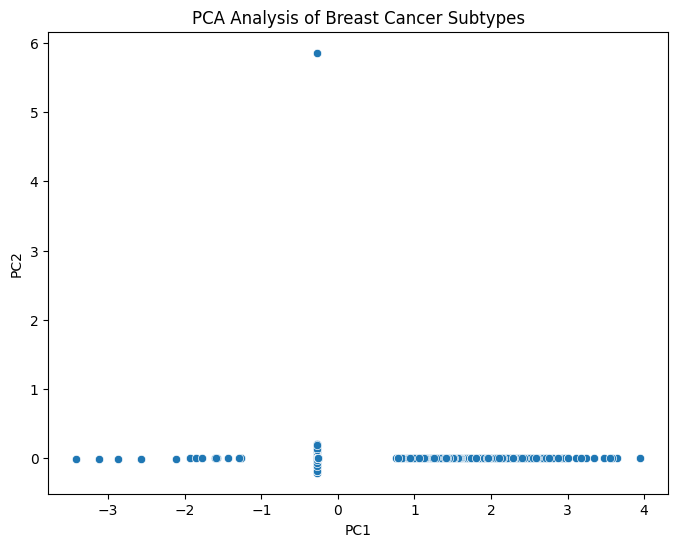

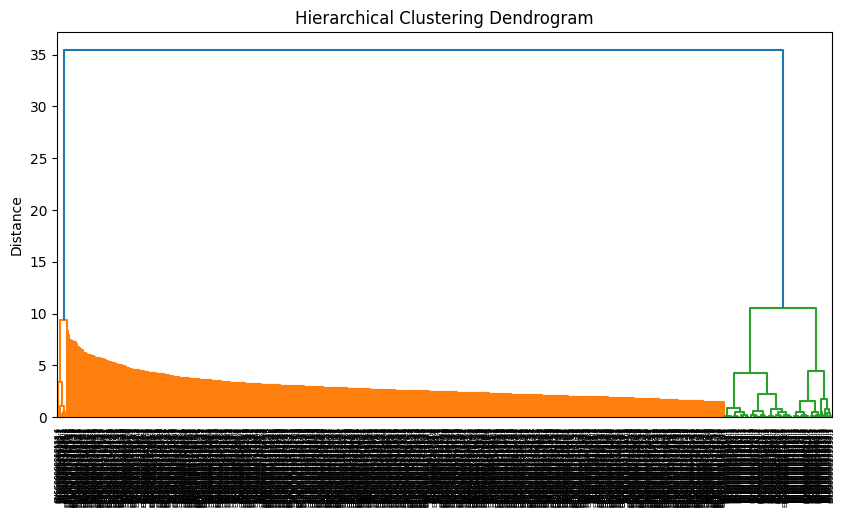

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram

# Load the DESeq2 results with gene symbols
file_path = "/content/DESeq2_GeneSymbols.csv"
df = pd.read_csv(file_path)

# Filter for differentially expressed genes (DEGs)
deg_df = df[(df["padj"] < 0.05) & (abs(df["log2FoldChange"] )> 1)]

# Check if the dataset has enough DEGs for PCA
if deg_df.shape[0] < 2:
    print("Not enough differentially expressed genes for PCA analysis.")
    exit()

# Prepare data for PCA (gene expression matrix)
pca_data = deg_df.pivot(index="GeneSymbol", columns="Unnamed: 0", values="log2FoldChange")
pca_data = pca_data.fillna(0)  # Replace NaN values with 0

# Convert column names and index to strings
pca_data.columns = pca_data.columns.astype(str)
pca_data.index = pca_data.index.astype(str)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pca_data.T)

# Plot PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Analysis of Breast Cancer Subtypes")
plt.show()

# Perform hierarchical clustering
linkage_matrix = linkage(pca_data.T, method="ward")
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, labels=pca_data.columns, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram")
plt.ylabel("Distance")
plt.show()


In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("DESeq2_GeneSymbols.csv")

# Display basic information
print(df.head())
print(df.info())
print(df.describe())


           Unnamed: 0     baseMean  log2FoldChange     lfcSE      stat  \
0  ENSG00000000003.15  3104.095977        0.044704  0.173195  0.258111   
1   ENSG00000000005.6   100.642201        2.654663  0.472213  5.621749   
2  ENSG00000000419.13  2304.327178       -0.025133  0.104952 -0.239470   
3  ENSG00000000457.14  1568.939325       -0.164026  0.105525 -1.554379   
4  ENSG00000000460.17   694.326636       -0.039279  0.150539 -0.260923   

         pvalue      padj       Ensembl_ID GeneSymbol  
0  7.963211e-01  0.905355  ENSG00000000003     TSPAN6  
1  1.890342e-08  0.000013  ENSG00000000005       TNMD  
2  8.107412e-01  0.912632  ENSG00000000419       DPM1  
3  1.200940e-01  0.363472  ENSG00000000457      SCYL3  
4  7.941518e-01  0.904580  ENSG00000000460      FIRRM  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60660 entries, 0 to 60659
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      

In [ ]:
# Filter significant DEGs
deg = df[(df['padj'] < 0.05) & (abs(df['log2FoldChange']) > 1)]
print(deg.shape)  # Number of significant DEGs
deg.to_csv("Significant_DEGs.csv", index=False)



(1215, 9)
